# House Prices - Advanced Regression Techniques

## Scikit Learn Intelex Installation

In [ ]:
!pip install scikit-learn-intelex -q --progress-bar off
!pip install optuna





     |████████████████████████████████| 302 kB 5.2 MB/s 
     |████████████████████████████████| 208 kB 52.2 MB/s 
     |████████████████████████████████| 80 kB 11.2 MB/s 
     |████████████████████████████████| 75 kB 5.5 MB/s 
     |████████████████████████████████| 144 kB 48.0 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
     |████████████████████████████████| 111 kB 64.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=9606fa9254a0e07be8e505f164e233ec50ff8129ef17d9e621d8be2a3478e0ae
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


## Defining Functions

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LassoCV
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split, KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.svm import NuSVR
from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from google.colab import files
import xgboost as xgb
import lightgbm as lgb
import sys
import os
import site
import optuna
sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))
from sklearnex import patch_sklearn
from google.colab import drive
patch_sklearn()

drive.mount('/content/drive')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Mounted at /content/drive


## Loading Data

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Data Science/Homework 2/input/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Business Data Science/Homework 2/input/test.csv")
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Business Data Science/Homework 2/input/sample_submission.csv')
pseudo = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Business Data Science/Homework 2/output/submission.csv')

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Adding a SalePrice column to test data to include our predictions that gave best score on Kaggle so far
test['SalePrice'] = np.log1p(pseudo['SalePrice'])
train["SalePrice"] = np.log1p(train["SalePrice"])

# Combining train and test dataset for preprocessing
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True)
y = train.SalePrice.values
y_all = np.expm1(all_data.SalePrice.values)
all_data.drop(['SalePrice'], axis=1, inplace=True)

## Feature Preprocessing and Engineering

### Null Values

In [ ]:
null_cols = (all_data.isnull().sum() / len(all_data))
null_cols = null_cols.drop(null_cols[null_cols == 0].index).sort_values(ascending=False)[:5]
print('Features with most Null Values')
print(null_cols)

Features with most Null Values
PoolQC         0.996574
MiscFeature    0.964029
Alley          0.932169
Fence          0.804385
FireplaceQu    0.486468
dtype: float64


The first five features have the most Null values, which can be replaced with appropriate values mentioned in data_description.txt file in Kaggle.

NA means 'No Feature' in the case of these columns

In [ ]:
# Replacing NA with None for the first 5 features
for col in null_cols.index[:5]:
  all_data[col] = all_data[col].fillna("None")

# Replacing all remaining null values with mean
all_data = all_data.fillna(all_data.mean())

### Meaningless Features

In [ ]:
# Removing Utilities feature because there is no predictive power
print('Utilities Feature distribution')
print(all_data.groupby(['Utilities'])['Utilities'].agg(['count']))
all_data = all_data.drop(['Utilities'], axis=1)

Utilities Feature distribution
           count
Utilities       
AllPub      2916
NoSeWa         1


### Categorical Variables

In [ ]:
# Conversion to categorical features
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [ ]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# Applying LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

### Additional Feature

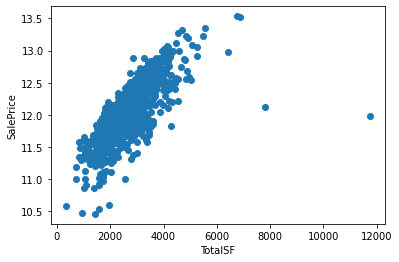

In [ ]:
# Adding a new total sqfootage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

plt.ylabel('SalePrice')
plt.xlabel('TotalSF')
plt.scatter(all_data[:ntrain]['TotalSF'], y)

### Skewed Features

In [ ]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("Skew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(5)

Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065


In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


### Dummy Features

In [ ]:
all_data = pd.get_dummies(all_data)

### Variance Analysis

In [ ]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Removing features that have the lowest variance (close to Zero)
a = pd.DataFrame(train.var()).sort_values(by=0).head(8)

print('Features sorted by Variance')
print(a)
train = train.drop(a.index, axis=1)
test = test.drop(a.index, axis=1)

Features sorted by Variance
                            0
Exterior2nd_CBlock   0.000685
Exterior1st_CBlock   0.000685
MiscFeature_TenC     0.000685
Exterior1st_ImStucc  0.000685
Condition2_RRAn      0.000685
RoofMatl_Roll        0.000685
Exterior1st_AsphShn  0.000685
RoofMatl_Membran     0.000685


### Non-Zero Features

In [ ]:
# Removing 30 features that contain more than 95% Zero's
zeros_columns = pd.DataFrame((train == 0).sum(axis=0)/len(train)).sort_values(by=0, ascending=False)
a = zeros_columns.head(30)
print('Features sorted by Proportion of Zero values')
print(zeros_columns.head(5))
train = train.drop(a.index, axis=1)
test = test.drop(a.index, axis=1)

all_data = pd.concat((train, test)).reset_index(drop=True)
X_train_new = train.copy()
X_test_new = test.copy()

Features sorted by Proportion of Zero values
                          0
Exterior2nd_Other  0.999315
Condition2_RRAe    0.999315
RoofMatl_Metal     0.999315
Electrical_Mix     0.999315
RoofMatl_ClyTile   0.999315


## Model Pipelines and Initialization

### Defining Functions

In [ ]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train_new.values)
    rmse= np.sqrt(-cross_val_score(model, X_train_new.values, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def objective_svr(trial):
    params ={
        'C': trial.suggest_float('C', 0.0001, 5.0),
        'nu':  trial.suggest_float('nu', 0.0, 1.0),
    }
    model = NuSVR(**params).fit(x_train, y_train)
    y_pred = model.predict(x_val)
    loss = np.sqrt(mean_squared_error(y_val, y_pred))
    return loss

### Generic Models
The model parameters have been optimized

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.45, gamma=0.045, learning_rate=0.05, max_depth=3, n_estimators=2500, subsample=0.5, silent=1, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=950, bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.23)

### NuSVR

#### Data Normalization

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(all_data, y_all, test_size = 0.1, random_state=0)

scaler_x = MinMaxScaler()
scaler_y = StandardScaler()

scaler_x.fit(x_train)
x_train = scaler_x.transform(x_train)
x_val = scaler_x.transform(x_val)
test = scaler_x.transform(test)

scaler_y.fit(y_train.reshape(-1, 1))
y_train = scaler_y.transform(y_train.reshape(-1, 1)).ravel()
y_val = scaler_y.transform(y_val.reshape(-1, 1)).ravel()

#### Parameter Optimization

In [ ]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=123), direction="minimize", pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective_svr, n_trials=250)

[I 2021-09-26 18:17:08,646] A new study created in memory with name: no-name-906aad5f-bce7-4512-8236-88388a598048
[I 2021-09-26 18:17:11,369] Trial 0 finished with value: 0.21537217634065983 and parameters: {'C': 3.482376281070749, 'nu': 0.28613933495037946}. Best is trial 0 with value: 0.21537217634065983.
[I 2021-09-26 18:17:14,011] Trial 1 finished with value: 0.2225311262912958 and parameters: {'C': 1.1343345826756592, 'nu': 0.5513147690828912}. Best is trial 0 with value: 0.21537217634065983.
[I 2021-09-26 18:17:18,394] Trial 2 finished with value: 0.20957862176507305 and parameters: {'C': 3.597372902030837, 'nu': 0.42310646012446096}. Best is trial 2 with value: 0.20957862176507305.
[I 2021-09-26 18:17:27,954] Trial 3 finished with value: 0.20835367152449882 and parameters: {'C': 4.903822915503239, 'nu': 0.6848297385848633}. Best is trial 3 with value: 0.20835367152449882.
[I 2021-09-26 18:17:30,946] Trial 4 finished with value: 0.21539563348069693 and parameters: {'C': 2.4047114

## Model Training

### Generic Models

In [ ]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1244 (0.0146)

ElasticNet score: 0.1245 (0.0146)

Kernel Ridge score: 0.1257 (0.0123)

Gradient Boosting score: 0.1194 (0.0099)



### XGB and LGBM

In [ ]:
model_xgb.fit(X_train_new, y)
xgb_train_pred = model_xgb.predict(X_train_new)
xgb_pred = np.expm1(model_xgb.predict(X_test_new))
print("XGB score: {:.4f}\n" .format(rmsle(y, xgb_train_pred)))

model_lgb.fit(X_train_new, y)
lgb_train_pred = model_lgb.predict(X_train_new)
lgb_pred = np.expm1(model_lgb.predict(X_test_new.values))
print("LGBM score: {:.4f}\n" .format(rmsle(y, lgb_train_pred)))

XGB score: 0.0625

LGBM score: 0.0712



### NuSVR

In [ ]:
full_x = np.concatenate((x_train, x_val), axis=0)
full_y = np.concatenate((y_train, y_val), axis=0)

final_model = NuSVR(**study.best_params).fit(full_x, full_y)

svr_pred = final_model.predict(test)
svr_pred = scaler_y.inverse_transform(svr_pred)

## Model Stacking

Average (ElasticNet, Gradiet Boost, Kernel Ridge, Lasso)

In [ ]:
models = (ENet, GBoost, KRR, lasso)
averaged_models = [clone(x) for x in models]

for model in averaged_models:
  model.fit(X_train_new.values, y)

stacked_train_pred = np.mean(np.column_stack([model.predict(X_train_new.values) for model in averaged_models]), axis=1)
stacked_pred = np.expm1(np.mean(np.column_stack([model.predict(X_test_new.values) for model in averaged_models]), axis=1))

print("Stacked Model RMSE: " + str(rmsle(y, stacked_train_pred)))

Stacked Model RMSE: 0.07661157599281569


## Model Ensembling & Prediction





The ensembling weights have been optimized

1.   Stacked Model: 32.5%
2.   XGB: 10%
3.   LGBM: 7.5%
4.   NuSVR: 50%

In [ ]:
ensemble = (0.5 * (stacked_pred*0.65 + xgb_pred*0.20 + lgb_pred*0.15)) + (0.5 * svr_pred)

sub = pd.DataFrame()
sub['Id'] = np.arange(1461, 2920, 1)
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Final Submission

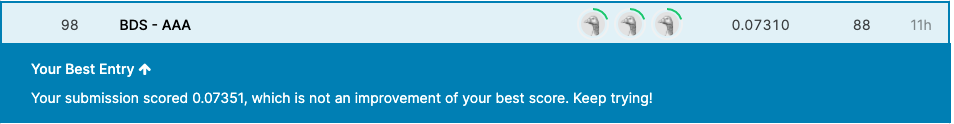